In [1]:
import os
import json
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [3]:
fname = "dataset/dataset.json"
fname = "dataset/jane_260523.json"

data = json.load(open(fname))

In [4]:
data[0]['motion']

[[-0.150683, 0.134337, 0.0160882, 2.51667, 2.77353, -1.18312, 1],
 [-0.148994, 0.135242, 0.0174539, 2.38156, 2.61776, -1.12849, 1],
 [-0.157089, 0.135142, 0.0826219, 2.49796, 2.32389, -1.12406, 1],
 [-0.223533, 0.0904979, 0.0516476, 1.50792, 1.60198, -1.35853, 1],
 [-0.222892, 0.0922946, 0.00158391, 1.11302, 1.55239, -1.35066, 1],
 [-0.198103, 0.110093, -0.0323373, 1.57282, 2.24051, -1.30137, 1],
 [-0.161837, 0.131846, -0.0292381, 2.07364, 2.69969, -1.17236, 1],
 [-0.126324, 0.139452, 0.0353268, 2.43754, 2.50184, -1.11569, 1],
 [-0.139401, 0.12983, 0.0468646, 2.42395, 2.49515, -1.19725, 1],
 [-0.141993, 0.128593, 0.042524, 2.55165, 2.65321, -1.21383, 1]]

# Load Data

In [2]:
fname_list = [
    "ben_260523.json",
    "jane_260523.json",
    "ken_270523.json",
    "ploy_270523.json",
    "may_270523.json",
    "paopao_270523.json",
    "raine_270523.json",
    "naenae_280523.json",
    "win_280523.json"
]
root_path = "dataset"
fname_list = [os.path.join(root_path, f) for f in fname_list]

In [3]:
data = []
for fname in fname_list:
    data += json.load(open(fname))

In [4]:
len(data)

1088

In [5]:
def report_class(data):
    label_count = {}
    for motion in data:
        label = motion["label"]
        if label not in label_count:
            label_count[label] = 0
        label_count[label] += 1
    print(label_count)

In [6]:
report_class(data)

{0: 275, 1: 270, 2: 273, 3: 270}


# Data Preprocessing

In [7]:
max_len = max([len(x['motion']) for x in data]) # find max length of the sequence to perform zero padding
print("Max Length : ", max_len)
num_classes = max(x['label'] for x in data) + 1 # find the total number of classes
print("Number of classes : ", num_classes)

Max Length :  26
Number of classes :  4


In [8]:
y = []
X = []
for x in data:
    # One-hot encoder
    tmp_y = np.zeros((num_classes))
    tmp_y[x['label']] = 1.0
    y.append(tmp_y)
    
    tmp_x = np.array(x['motion'])[:,:3] # exclude the last dimension corresponding to button pressing
    tmp_x = np.concatenate([tmp_x, np.zeros((max_len - tmp_x.shape[0], tmp_x.shape[1]))]) # zero padding
    X.append(tmp_x)
X = np.stack(X)
y = np.stack(y)


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
print(X_train.shape[0])
print(X_test.shape[0])

870
218


# Model CNN

In [11]:
def make_model(input_shape):
    input_layer = tf.keras.layers.Input(input_shape)

    conv1 = tf.keras.layers.Conv1D(filters=8, kernel_size=3, padding="same")(input_layer)
    conv1 = tf.keras.layers.BatchNormalization()(conv1)
    conv1 = tf.keras.layers.ReLU()(conv1)

    conv2 = tf.keras.layers.Conv1D(filters=8, kernel_size=3, padding="same")(conv1)
    conv2 = tf.keras.layers.BatchNormalization()(conv2)
    conv2 = tf.keras.layers.ReLU()(conv2)

    conv3 = tf.keras.layers.Conv1D(filters=8, kernel_size=3, padding="same")(conv2)
    conv3 = tf.keras.layers.BatchNormalization()(conv3)
    conv3 = tf.keras.layers.ReLU()(conv3)

    gap = tf.keras.layers.GlobalAveragePooling1D()(conv3)

    output_layer =tf.keras.layers.Dense(num_classes, activation="softmax")(gap)

    return tf.keras.models.Model(inputs=input_layer, outputs=output_layer)


model = make_model(input_shape=X_train.shape[1:])
tf.keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [12]:
model_name = "best_cnn_model.h5"
epochs = 400
batch_size = 16

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        model_name, save_best_only=True, monitor="val_loss"
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    ),
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["categorical_accuracy"],
)
history = model.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

Epoch 1/400
44/44 [==============================] - 2s 8ms/step - loss: 1.3946 - categorical_accuracy: 0.2486 - val_loss: 1.3856 - val_categorical_accuracy: 0.2644 - lr: 0.0010
Epoch 2/400
44/44 [==============================] - 0s 2ms/step - loss: 1.2759 - categorical_accuracy: 0.4727 - val_loss: 1.3861 - val_categorical_accuracy: 0.2644 - lr: 0.0010
Epoch 3/400
44/44 [==============================] - 0s 2ms/step - loss: 1.1879 - categorical_accuracy: 0.6250 - val_loss: 1.3963 - val_categorical_accuracy: 0.2644 - lr: 0.0010
Epoch 4/400
44/44 [==============================] - 0s 2ms/step - loss: 1.1154 - categorical_accuracy: 0.7356 - val_loss: 1.4543 - val_categorical_accuracy: 0.2644 - lr: 0.0010
Epoch 5/400
44/44 [==============================] - 0s 2ms/step - loss: 1.0480 - categorical_accuracy: 0.7672 - val_loss: 1.5965 - val_categorical_accuracy: 0.2644 - lr: 0.0010
Epoch 6/400
44/44 [==============================] - 0s 2ms/step - loss: 0.9861 - categorical_accuracy: 0.8046

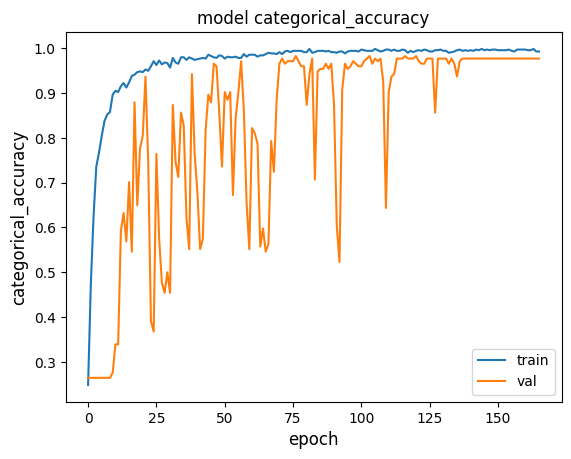

In [13]:
metric = "categorical_accuracy"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()

In [14]:
model = tf.keras.models.load_model(model_name)

test_loss, test_acc = model.evaluate(X_test, y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

7/7 [==============================] - 0s 1ms/step - loss: 0.0653 - categorical_accuracy: 0.9817
Test accuracy 0.9816513657569885
Test loss 0.06525740772485733


In [15]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)
y_pred_bool = np.argmax(y_pred, axis=1)
y_test_bool = np.argmax(y_test, axis=1)

print(classification_report(y_test_bool, y_pred_bool))

7/7 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.98      0.96      0.97        50
           1       0.95      1.00      0.97        55
           2       1.00      0.98      0.99        57
           3       1.00      0.98      0.99        56

    accuracy                           0.98       218
   macro avg       0.98      0.98      0.98       218
weighted avg       0.98      0.98      0.98       218



# Model LSTM

In [16]:
def make_model(n_features):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.LSTM(100, input_shape=(None, n_features)))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(100, activation='relu'))
    model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))
    return model


model = make_model(n_features=X_train.shape[2])

In [17]:
model_name = 'best_lstm_model.h5'
epochs = 200
batch_size = 16

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        model_name, save_best_only=True, monitor="val_loss"
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    ),
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["categorical_accuracy"],
)
history = model.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

Epoch 1/200
44/44 [==============================] - 2s 17ms/step - loss: 1.3805 - categorical_accuracy: 0.2586 - val_loss: 1.3308 - val_categorical_accuracy: 0.3621 - lr: 0.0010
Epoch 2/200
44/44 [==============================] - 0s 9ms/step - loss: 1.3178 - categorical_accuracy: 0.3218 - val_loss: 1.2236 - val_categorical_accuracy: 0.3966 - lr: 0.0010
Epoch 3/200
44/44 [==============================] - 0s 10ms/step - loss: 1.2978 - categorical_accuracy: 0.3707 - val_loss: 1.2139 - val_categorical_accuracy: 0.3966 - lr: 0.0010
Epoch 4/200
44/44 [==============================] - 0s 8ms/step - loss: 1.2739 - categorical_accuracy: 0.3922 - val_loss: 1.2483 - val_categorical_accuracy: 0.4080 - lr: 0.0010
Epoch 5/200
44/44 [==============================] - 0s 9ms/step - loss: 1.2686 - categorical_accuracy: 0.3721 - val_loss: 1.2040 - val_categorical_accuracy: 0.4080 - lr: 0.0010
Epoch 6/200
44/44 [==============================] - 0s 8ms/step - loss: 1.2477 - categorical_accuracy: 0.41

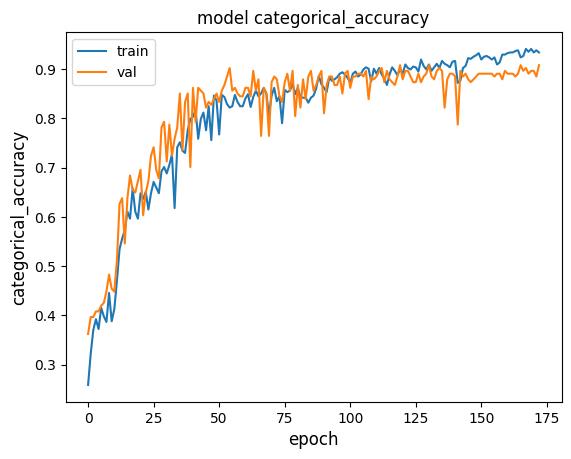

In [18]:
metric = "categorical_accuracy"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()

In [19]:
model = tf.keras.models.load_model(model_name)

test_loss, test_acc = model.evaluate(X_test, y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

7/7 [==============================] - 0s 4ms/step - loss: 0.3147 - categorical_accuracy: 0.9083
Test accuracy 0.9082568883895874
Test loss 0.3147066533565521


In [20]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)
y_pred_bool = np.argmax(y_pred, axis=1)
y_test_bool = np.argmax(y_test, axis=1)

print(classification_report(y_test_bool, y_pred_bool))

7/7 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.88      0.86      0.87        50
           1       0.86      0.98      0.92        55
           2       0.93      0.89      0.91        57
           3       0.98      0.89      0.93        56

    accuracy                           0.91       218
   macro avg       0.91      0.91      0.91       218
weighted avg       0.91      0.91      0.91       218

